In [2]:
from functools import reduce
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from scipy.special import comb
from scipy.stats import pearsonr, spearmanr, gmean
from tqdm import tqdm

from correlation import compute_segment_scores, compute_direct_assessment_correlations

# from utils import (
#     read_amt_ratings,
#     read_sentences_to_evaluate,
#     read_test_set,
#     collect_references,
#     sigmoid,
#     read_lines
# )

# Read the Test Suites Data

## Simplicity-DA (Continuous Scores)

In [3]:
df_simplicityDA = pd.read_csv("../data/simplicity_DA.csv")

Text(0, 0.5, 'Frequency')

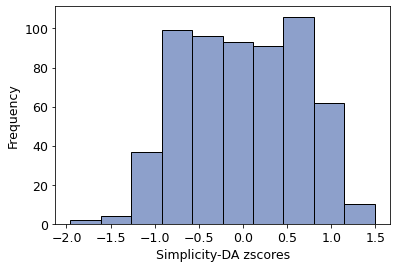

In [5]:
plt.rcParams.update({'font.size': 12.5})
plt.hist(df_simplicityDA['simplicity_zscore'], edgecolor='black', color=['#8da0cb'])
plt.xlabel("Simplicity-DA zscores")
plt.ylabel("Frequency")
# plt.savefig('scores_distribution_simplicity_DA.pdf', dpi=300, bbox_inches='tight')

## Simplicity Gain (Discrete Scores)

In [8]:
df_simplicity_gain = pd.read_csv("../data/simplicity_gain.csv")

Text(0, 0.5, 'Frequency')

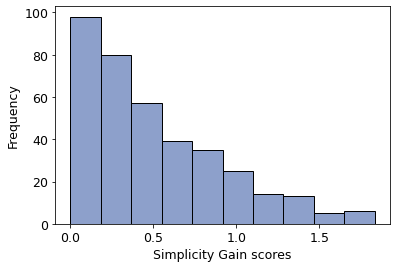

In [13]:
plt.hist(df_simplicity_gain['simplicity_gain'], edgecolor='black', color=['#8da0cb'])
plt.xlabel("Simplicity Gain scores")
plt.ylabel("Frequency")
# plt.savefig('scores_distribution_simplicity_gain.pdf', dpi=300, bbox_inches='tight')

## Structural Simplicity (Discrete Scores)

In [14]:
df_struct_simplicity = pd.read_csv("../data/structural_simplicity.csv")

Text(0, 0.5, 'Frequency')

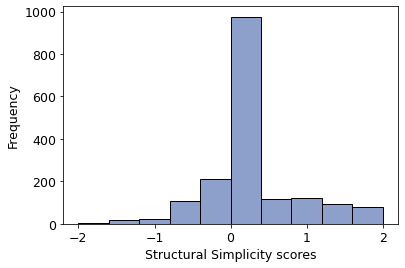

In [15]:
plt.hist(df_struct_simplicity['structural_simplicity'], edgecolor='black', color=['#8da0cb'])
plt.xlabel("Structural Simplicity scores")
plt.ylabel("Frequency")
# plt.savefig('scores_distribution_structural_simplicity.pdf', dpi=300, bbox_inches='tight')

# Metrics across Simplicity Levels

In [33]:
def compute_correlations_per_half(df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols):
    results = {}
    for aspect in aspects:
        if f"{aspect}_zscore" in df_benchmark.columns:
            df_benchmark_sorted = df_benchmark.sort_values(by=[f"{aspect}_zscore"])
        else:
            df_benchmark_sorted = df_benchmark.sort_values(by=[aspect])
        df_scores_low = df_benchmark_sorted.head(int(len(df_benchmark_sorted) / 2))
        df_scores_high = df_benchmark_sorted.tail(int(len(df_benchmark_sorted) / 2))
        print(f"{aspect}: High ({len(df_scores_high)}) - Low ({len(df_scores_low)}) - All ({len(df_benchmark)})")
        for quality, df_scores in {'low': df_scores_low, 'high': df_scores_high, 'all': df_benchmark}.items():
            for test_set in test_sets:
                print(f"Computing for {quality} scores - {test_set} references")
                df_metrics = df_segment_metrics[df_segment_metrics.test_set==test_set].drop(columns=['test_set'])
                results[(quality, aspect, test_set)] = compute_direct_assessment_correlations(df_scores, 
                                                                                              df_metrics, 
                                                                                              aspect, 
                                                                                              segment_id_cols=segment_id_cols)
                print()
    return results

In [17]:
def pprint_correlations(results_correlations, aspects, test_sets):
    correlations = []
    for aspect in aspects:
        for quality in ['low', 'high', 'all']:
            for test_set in test_sets:
                df_corr, _ = results_correlations[(quality, aspect, test_set)]
                df_corr = df_corr[['metric', 'corr']]
                df_corr.columns = ["metric", f"{aspect}_{test_set}_{quality}"]
                correlations.append(df_corr)

    df_corr_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=["metric"], how="outer"), correlations
    )
    
    return df_corr_metrics

## Simplicity-DA

In [18]:
df_metrics_simplicity = pd.read_csv("../data/metrics_per_sentence/metrics_simplicity_DA.csv")

In [19]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'samsa', 'fkgl', 'fkbleu', 'ibleu', 
                      'amean_bleu_sari', 'amean_sari_samsa', 'amean_bleu_samsa', 'amean_bleu_sari_samsa',
                      'gmean_bleu_sari', 'gmean_sari_samsa', 'gmean_bleu_samsa', 'gmean_bleu_sari_samsa',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

In [20]:
df_metrics_simplicity = df_metrics_simplicity[['sent_id', 'sys_name', 'test_set'] + METRICS_TO_ANALYSE]

In [21]:
EVAL_DATASETS = ['asset', 'turk', 'hsplit']

In [34]:
results_simplicity = compute_correlations_per_half(
                        df_simplicityDA, 
                        df_metrics_simplicity, 
                        aspects=['simplicity'], 
                        test_sets=EVAL_DATASETS + ['all'], 
                        segment_id_cols=['sent_id','sys_name']
                    )

simplicity: High (300) - Low (300) - All (600)
Computing for low scores - asset references
Computing correlations...
Determining if the difference in performance is significant...

Computing for low scores - turk references
Computing correlations...
Determining if the difference in performance is significant...

Computing for low scores - hsplit references
Computing correlations...
Determining if the difference in performance is significant...

Computing for low scores - all references
Computing correlations...
Determining if the difference in performance is significant...

Computing for high scores - asset references
Computing correlations...
Determining if the difference in performance is significant...

Computing for high scores - turk references
Computing correlations...
Determining if the difference in performance is significant...

Computing for high scores - hsplit references
Computing correlations...
Determining if the difference in performance is significant...

Computing for 

In [39]:
# (low/high/all, simplicity, asset/turk/hsplit/all) [O:correlations, 1:significance]
results_simplicity[('all', 'simplicity', 'asset')][0]

,metric,corr,p_value,is_winner
0,bertscore_P,0.617463,2.413042e-64,True
1,bertscore_F1,0.572982,1.195520e-53,False
2,ibleu,0.503749,6.297491e-40,False
3,amean_bleu_sari,0.502735,9.498500e-40,False
4,bertscore_R,0.499577,3.381328e-39,False
5,bleu,0.496336,1.228257e-38,False
6,gmean_bleu_sari,0.475908,3.055152e-35,False
7,amean_bleu_sari_samsa,0.418595,7.465983e-27,False
8,amean_bleu_samsa,0.380113,4.626515e-22,False
9,sari,0.358708,1.170311e-19,False


In [41]:
df_corr_metrics_simplicity = pprint_correlations(results_simplicity, aspects=['simplicity'], test_sets=EVAL_DATASETS + ['all'])

In [42]:
df_aux = df_corr_metrics_simplicity[['metric', 
                            'simplicity_asset_low', 'simplicity_asset_high', 'simplicity_asset_all',
                           ]].sort_values(by=['simplicity_asset_all'], ascending=False)

In [28]:
# df_aux = df_corr_metrics_simplicity[['metric', 
#                             'simplicity_asset_low', 'simplicity_asset_high', 'simplicity_asset_all',
#                             'simplicity_all_low', 'simplicity_all_high', 'simplicity_all_all'
#                            ]].sort_values(by=['simplicity_all_all'], ascending=False)

In [43]:
print(df_aux.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrr}
\toprule
               metric &  simplicity\_asset\_low &  simplicity\_asset\_high &  simplicity\_asset\_all \\
\midrule
          bertscore\_P &                 0.512 &                  0.287 &                 0.617 \\
         bertscore\_F1 &                 0.518 &                  0.224 &                 0.573 \\
                ibleu &                 0.398 &                  0.253 &                 0.504 \\
      amean\_bleu\_sari &                 0.417 &                  0.239 &                 0.503 \\
          bertscore\_R &                 0.471 &                  0.172 &                 0.500 \\
                 bleu &                 0.405 &                  0.235 &                 0.496 \\
      gmean\_bleu\_sari &                 0.408 &                  0.215 &                 0.476 \\
amean\_bleu\_sari\_samsa &                 0.388 &                  0.170 &                 0.419 \\
     amean\_bleu\_samsa &                 0.355 &             

### Plot a matrix showing the results of the Williams Test for significance in differences in correlation

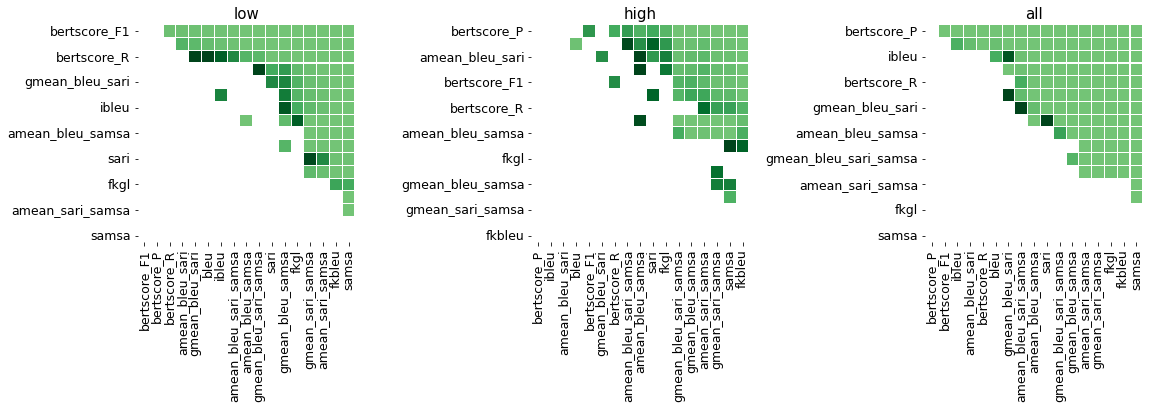

In [45]:
aspect_to_plot = 'simplicity'
test_set_to_plot = 'asset' # asset/turk/hsplit/all
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
i = 0
for (split, aspect, test_set), (_, df_sig) in results_simplicity.items():
    if aspect == aspect_to_plot and test_set == test_set_to_plot:
        ax = axes[i]
        sns.heatmap(df_sig, cmap="Greens", center=0.0, linewidth=0.05, cbar=False, robust=True, square=True, ax=ax)
        ax.set_title(split)
        i+=1 
# plt.savefig('significance_simplicityDA.pdf', dpi=300, bbox_inches='tight')

/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

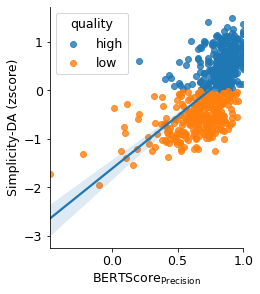

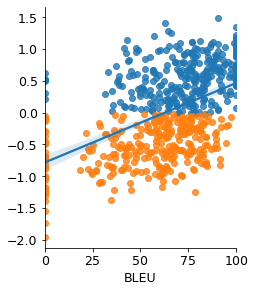

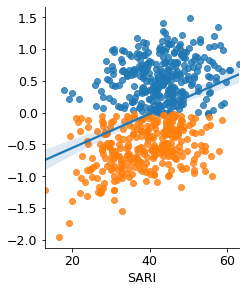

In [38]:
metric_name = {'bertscore_P': '$BERTScore_{Precision}$', 'bleu': 'BLEU', 'sari': 'SARI'}
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 12.5})
# fig, axes = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)
for metric in ['bertscore_P', 'bleu', 'sari']:
    auto_scores = df_metrics_simplicity[df_metrics_simplicity['test_set']=='asset'][['sent_id','sys_name', metric]]
    
    df_human_scores = df_benchmark_simplicity[['sent_id','sys_name', 'simplicity_zscore']]
    df_human_scores = df_human_scores.sort_values(by=['simplicity_zscore'])
    df_human_scores['quality'] = 'low'
    df_human_scores['quality'].iloc[int(len(df_human_scores) / 2):] = 'high'

    df_aux = pd.merge(auto_scores, df_human_scores, on=['sent_id','sys_name'])

    corr, pvalue = pearsonr(df_aux[metric], df_aux['simplicity_zscore'])
    
    graph = sns.lmplot(x=metric, y='simplicity_zscore', hue='quality', data=df_aux, fit_reg=False, legend_out=False, height=4, aspect=0.9)
    
    reg_plot = sns.regplot(x=metric, y='simplicity_zscore', data=df_aux, scatter=False, ax=graph.axes[0, 0])
    
    if metric == "bertscore_P":
        reg_plot.set(xlabel=metric_name[metric], ylabel='Simplicity-DA (zscore)')
    else:
        reg_plot.set(xlabel=metric_name[metric], ylabel='')
        graph._legend.remove()
    
    plt.savefig(f'{metric}_vs_simplicityDA.pdf', dpi=300, bbox_inches='tight')
    
#    ax.set_title(f"r = {corr:.3f}") # ax.set_title(f"r = {corr:.3f} ({pvalue:.4f})")

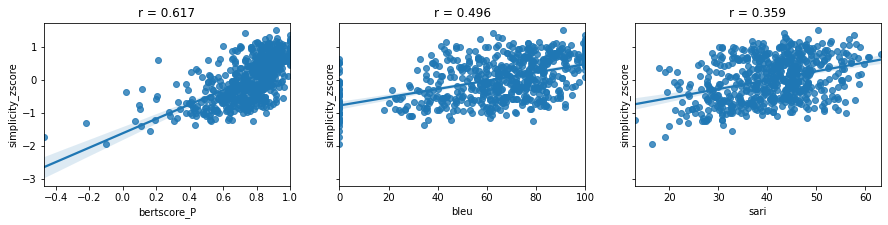

In [36]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)
for ax, metric in zip(axes, ['bertscore_P', 'bleu', 'sari']):
    auto_scores = df_metrics_simplicity[df_metrics_simplicity['test_set']=='asset'][['sent_id','sys_name', metric]]
    
    df_human_scores = df_benchmark_simplicity[['sent_id','sys_name', 'simplicity_zscore']]
#     df_human_scores = df_human_scores.sort_values(by=['simplicity_zscore'])
#     df_human_scores['quality'] = 'low'
#     df_human_scores['quality'].iloc[int(len(df_human_scores_sorted) / 2):] = 'high'

    df_aux = pd.merge(auto_scores, df_human_scores, on=['sent_id','sys_name'])

    corr, pvalue = pearsonr(df_aux[metric], df_aux['simplicity_zscore'])
    
    # graph = sns.lmplot(x=metric, y='simplicity_zscore', hue='quality', data=df_aux, fit_reg=False)
    #Use regplot to plot the regression line for the whole points
    # sns.regplot(x=metric, y='simplicity_zscore', data=df_aux, scatter=False, ax=graph.axes[0, 0])
    sns.regplot(x=metric, y='simplicity_zscore', data=df_aux, scatter=True, ax=ax)
    

    ax.set_title(f"r = {corr:.3f}") # ax.set_title(f"r = {corr:.3f} ({pvalue:.4f})")
#  plt.savefig('metrics_vs_simplicityDA.pdf', dpi=300, bbox_inches='tight')

## Simplicity Gain

In [39]:
df_metrics_simplicity_gain = pd.read_csv("data/metrics_segment_benchmark_simplicity_gain.csv")

In [40]:
df_benchmark_simplicity_gain['simplicity_gain_zscore'] = df_benchmark_simplicity_gain['simplicity_gain']

In [41]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'samsa', 'fkgl', 'fkbleu', 'ibleu', 
                      'amean_bleu_sari', 'amean_sari_samsa', 'amean_bleu_samsa', 'amean_bleu_sari_samsa',
                      'gmean_bleu_sari', 'gmean_sari_samsa', 'gmean_bleu_samsa', 'gmean_bleu_sari_samsa',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

In [42]:
df_metrics_simplicity_gain = df_metrics_simplicity_gain[['sent_id', 'sys_name', 'test_set'] + METRICS_TO_ANALYSE]

In [43]:
results_simplicity_gain = compute_correlations_per_quartile(df_benchmark_simplicity_gain, df_metrics_simplicity_gain, 
                                                           aspects=['simplicity_gain'], test_sets=['turk'], segment_id_cols=['sent_id','sys_name'])

simplicity_gain: High (186) - Low (186) - All (372)
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...


In [44]:
results_simplicity_gain[('all', 'simplicity_gain', 'turk')][0]

,metric,corr,p_value,is_winner
0,sari,0.331360,5.540003e-11,True
1,bertscore_F1,0.247146,1.394344e-06,False
2,bertscore_R,0.240694,2.654025e-06,False
3,bertscore_P,0.240657,2.663539e-06,False
4,gmean_bleu_sari,0.214157,3.113099e-05,False
5,amean_bleu_sari,0.187296,2.807280e-04,False
6,gmean_bleu_sari_samsa,0.150767,3.559357e-03,False
7,fkgl,0.147268,4.422060e-03,False
8,gmean_sari_samsa,0.140655,6.582599e-03,False
9,amean_bleu_sari_samsa,0.128415,1.318583e-02,False


In [45]:
df_corr_metrics_simplicity_gain = pprint_correlations(results_simplicity_gain, aspects=['simplicity_gain'], test_sets=['turk'])

In [46]:
df_corr_metrics_simplicity_gain

,metric,simplicity_gain_turk_low,simplicity_gain_turk_high,simplicity_gain_turk_all
0,sari,0.291893,0.239562,0.331360
1,gmean_bleu_sari,0.245509,0.177108,0.214157
2,amean_bleu_sari,0.222588,0.172219,0.187296
3,bertscore_R,0.220985,0.217286,0.240694
4,bertscore_F1,0.215418,0.236093,0.247146
5,bertscore_P,0.208575,0.230697,0.240657
6,amean_bleu_sari_samsa,0.207139,0.139321,0.128415
7,gmean_bleu_sari_samsa,0.203616,0.144278,0.150767
8,gmean_sari_samsa,0.189218,0.117490,0.140655
9,amean_sari_samsa,0.183490,0.103927,0.099293


In [76]:
print(df_corr_metrics_simplicity_gain.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrr}
\toprule
                metric &  simplicity\_gain\_turk\_low &  simplicity\_gain\_turk\_high &  simplicity\_gain\_turk\_all \\
\midrule
                  sari &                     0.292 &                      0.240 &                     0.331 \\
       gmean\_bleu\_sari &                     0.246 &                      0.177 &                     0.214 \\
       amean\_bleu\_sari &                     0.223 &                      0.172 &                     0.187 \\
           bertscore\_R &                     0.221 &                      0.217 &                     0.241 \\
          bertscore\_F1 &                     0.215 &                      0.236 &                     0.247 \\
           bertscore\_P &                     0.209 &                      0.231 &                     0.241 \\
 amean\_bleu\_sari\_samsa &                     0.207 &                      0.139 &                     0.128 \\
 gmean\_bleu\_sari\_samsa &                     0.204

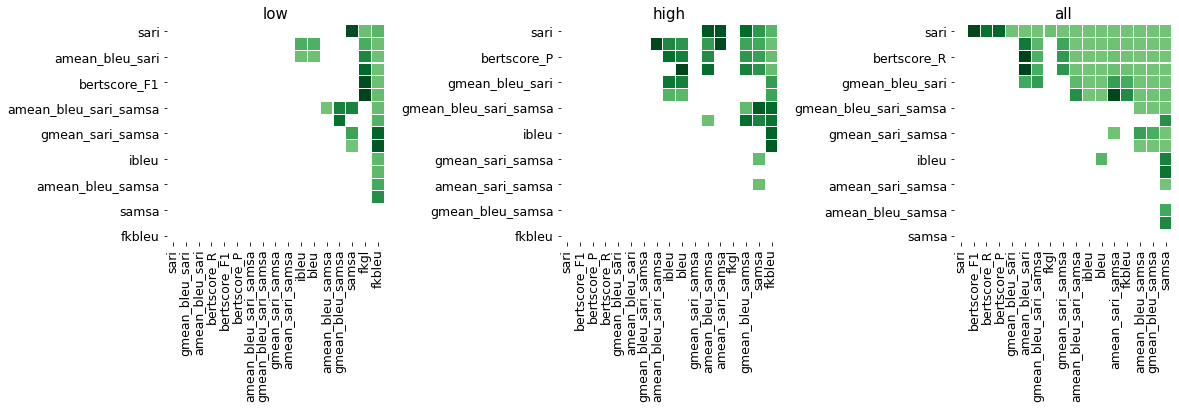

In [47]:
aspect_to_plot = 'simplicity_gain'
test_set_to_plot = 'turk'
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
i = 0
for (split, aspect, test_set), (_, df_sig) in results_simplicity_gain.items():
    if aspect == aspect_to_plot and test_set == test_set_to_plot:
        ax = axes[i]
        sns.heatmap(df_sig, cmap="Greens", center=0.0, linewidth=0.05, cbar=False, robust=True, square=True, ax=ax)
        ax.set_title(split)
        i+=1 
plt.savefig('significance_quality_simplicity_gain_complete.pdf', dpi=300, bbox_inches='tight')

In [78]:
df_metrics_simplicity_gain

,sent_id,sys_name,test_set,bleu,sari,samsa,fkgl,fkbleu,ibleu,amean_bleu_sari,amean_sari_samsa,amean_bleu_samsa,amean_bleu_sari_samsa,gmean_bleu_sari,gmean_sari_samsa,gmean_bleu_samsa,gmean_bleu_sari_samsa,bertscore_P,bertscore_R,bertscore_F1
0,1,PBMT-R,asset,66.585664,39.817534,37.50,18.734545,18.203832,54.614596,53.201599,38.658767,52.042832,47.967733,51.490552,38.641397,49.969615,46.326425,0.723299,0.729734,0.724048
1,1,PBMT-R,turk,58.180890,29.002769,37.50,18.734545,15.682543,47.050300,43.591830,33.251384,47.840445,41.561220,41.078059,32.978839,46.709564,39.848964,0.780699,0.738619,0.759971
2,1,PBMT-R,hsplit,54.396930,60.948920,37.50,18.734545,15.441445,46.326964,57.672925,49.224460,45.948465,50.948616,57.579806,47.807787,45.165084,49.910343,0.728504,0.563011,0.639868
3,1,SBMT-BLEU,asset,52.752476,37.042616,18.75,16.477778,2.177284,43.776369,44.897546,27.896308,35.751238,36.181697,44.205087,26.354298,31.450102,33.213547,0.742001,0.781063,0.761853
4,1,SBMT-BLEU,turk,39.698403,33.052623,18.75,16.477778,1.592946,32.027704,36.375513,25.901312,29.224202,30.500342,36.223423,24.894511,27.282688,29.084398,0.789708,0.769728,0.780058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,100,SBMT-FKBLEU,turk,80.705573,46.792417,43.75,8.009091,0.872106,64.564458,63.748995,45.271209,62.227786,57.082663,61.452492,45.245643,59.421114,54.872198,0.964293,0.964296,0.964353
1112,100,SBMT-FKBLEU,hsplit,36.791347,22.211538,43.75,8.009091,0.352856,26.122905,29.501443,32.980769,40.270674,34.250962,28.586578,31.172982,40.120088,32.943327,0.870593,0.720448,0.794868
1113,100,SBMT-SARI,asset,100.000000,44.411410,43.75,8.009091,1.106664,81.929443,72.205705,44.080705,71.875000,62.720470,66.641886,44.079464,66.143783,57.919420,0.913790,0.950957,0.932426
1114,100,SBMT-SARI,turk,80.705573,46.792417,43.75,8.009091,0.872106,64.564458,63.748995,45.271209,62.227786,57.082663,61.452492,45.245643,59.421114,54.872198,0.964293,0.964296,0.964353


/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

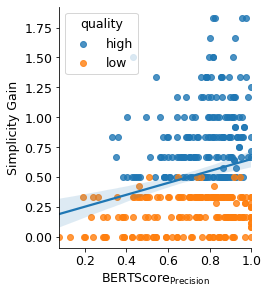

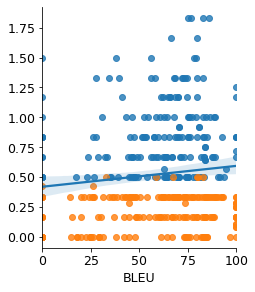

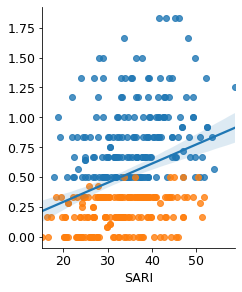

In [61]:
metric_name = {'bertscore_P': '$BERTScore_{Precision}$', 'bleu': 'BLEU', 'sari': 'SARI'}
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 12.5})
for metric in ['bertscore_P', 'bleu', 'sari']:
    auto_scores = df_metrics_simplicity_gain[df_metrics_simplicity_gain['test_set']=='turk'][['sent_id','sys_name', metric]]
    
    df_human_scores = df_benchmark_simplicity_gain[['sent_id','sys_name', 'simplicity_gain']]
    df_human_scores = df_human_scores.sort_values(by=['simplicity_gain'])
    df_human_scores['quality'] = 'low'
    df_human_scores['quality'].iloc[int(len(df_human_scores) / 2):] = 'high'

    df_aux = pd.merge(auto_scores, df_human_scores, on=['sent_id','sys_name'])

    corr, pvalue = pearsonr(df_aux[metric], df_aux['simplicity_gain'])
    
    graph = sns.lmplot(x=metric, y='simplicity_gain', hue='quality', data=df_aux, fit_reg=False, legend_out=False, height=4, aspect=0.9)
    reg_plot = sns.regplot(x=metric, y='simplicity_gain', data=df_aux, scatter=False, ax=graph.axes[0, 0])
    
    if metric == "bertscore_P":
        reg_plot.set(xlabel=metric_name[metric], ylabel='Simplicity Gain')
    else:
        reg_plot.set(xlabel=metric_name[metric], ylabel='')
        graph._legend.remove()
    
    # plt.title(f"r = {corr:.3f}")
    plt.savefig(f'{metric}_vs_simplicity_gain.pdf', dpi=300, bbox_inches='tight')

## Structural Simplicity

In [50]:
df_metrics_struct_simplicity = pd.read_csv("data/metrics_segment_benchmark_structural_simplicity.csv")

In [51]:
df_benchmark_struct_simplicity['structural_simplicity_zscore'] = df_benchmark_struct_simplicity['structural_simplicity']

In [52]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'samsa', 'fkgl', 'fkbleu', 'ibleu', 
                      'amean_bleu_sari', 'amean_sari_samsa', 'amean_bleu_samsa', 'amean_bleu_sari_samsa',
                      'gmean_bleu_sari', 'gmean_sari_samsa', 'gmean_bleu_samsa', 'gmean_bleu_sari_samsa',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

In [53]:
df_metrics_struct_simplicity = df_metrics_struct_simplicity[['sent_id', 'sys_name', 'test_set'] + METRICS_TO_ANALYSE]

In [54]:
results_struct_simplicity = compute_correlations_per_quartile(df_benchmark_struct_simplicity, df_metrics_struct_simplicity, 
                                                              aspects=['structural_simplicity'], test_sets=['hsplit'], segment_id_cols=['sent_id','sys_name'])

structural_simplicity: High (875) - Low (875) - All (1750)
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...


In [55]:
results_struct_simplicity[('high', 'structural_simplicity', 'hsplit')][0]

,metric,corr,p_value,is_winner
0,bleu,0.642701,4.095064e-103,True
1,ibleu,0.634623,8.344831e-100,False
2,fkbleu,0.608230,1.190281e-89,False
3,amean_bleu_samsa,0.607590,2.041297e-89,False
4,bertscore_R,0.601000,4.930421e-87,False
5,amean_bleu_sari_samsa,0.600780,5.910201e-87,False
6,amean_bleu_sari,0.598914,2.729308e-86,False
7,gmean_bleu_sari,0.589115,7.134608e-83,False
8,gmean_bleu_samsa,0.568942,3.408111e-76,False
9,gmean_bleu_sari_samsa,0.553312,2.502640e-71,False


In [56]:
df_corr_metrics_struct_simplicity = pprint_correlations(results_struct_simplicity, aspects=['structural_simplicity'], test_sets=['hsplit'])

In [57]:
df_corr_metrics_struct_simplicity

,metric,structural_simplicity_hsplit_low,structural_simplicity_hsplit_high,structural_simplicity_hsplit_all
0,bertscore_P,0.552367,0.310326,0.090183
1,bertscore_F1,0.482993,0.529174,0.325369
2,bleu,0.420684,0.642701,0.443223
3,bertscore_R,0.410703,0.601000,0.429968
4,ibleu,0.407928,0.634623,0.436215
5,fkbleu,0.395093,0.608230,0.364153
6,amean_bleu_sari,0.345771,0.598914,0.430551
7,gmean_bleu_sari,0.329143,0.589115,0.437741
8,gmean_bleu_samsa,0.293120,0.568942,0.370390
9,gmean_bleu_sari_samsa,0.290611,0.553312,0.365994


In [62]:
print(df_corr_metrics_struct_simplicity.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrr}
\toprule
                metric &  structural\_simplicity\_hsplit\_low &  structural\_simplicity\_hsplit\_high &  structural\_simplicity\_hsplit\_all \\
\midrule
           bertscore\_P &                             0.552 &                              0.310 &                             0.090 \\
          bertscore\_F1 &                             0.483 &                              0.529 &                             0.325 \\
                  bleu &                             0.421 &                              0.643 &                             0.443 \\
           bertscore\_R &                             0.411 &                              0.601 &                             0.430 \\
                 ibleu &                             0.408 &                              0.635 &                             0.436 \\
                fkbleu &                             0.395 &                              0.608 &                             0.364 \\
   

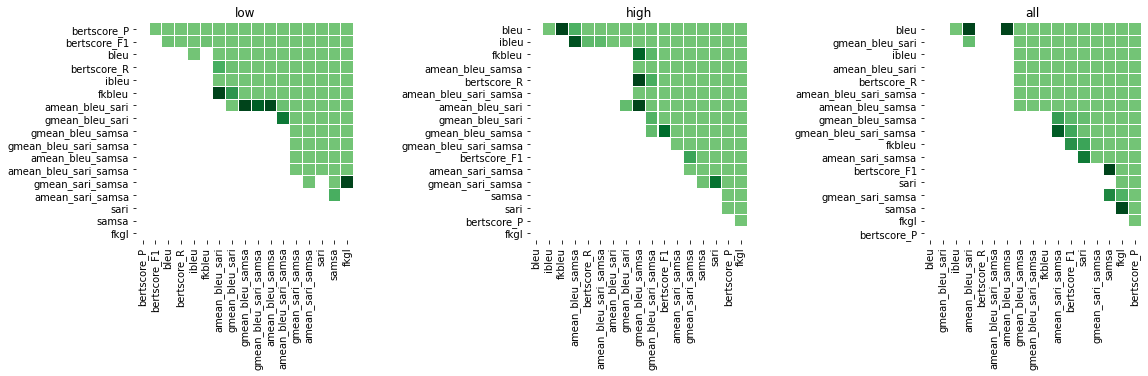

In [111]:
aspect_to_plot = 'structural_simplicity'
test_set_to_plot = 'hsplit'
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
i = 0
for (split, aspect, test_set), (_, df_sig) in results_struct_simplicity.items():
    if aspect == aspect_to_plot and test_set == test_set_to_plot:
        ax = axes[i]
        sns.heatmap(df_sig, cmap="Greens", center=0.0, linewidth=0.05, cbar=False, robust=True, square=True, ax=ax)
        ax.set_title(split)
        i+=1 
plt.savefig('significance_quality_structural_simplicity_complete.pdf', dpi=300, bbox_inches='tight')

In [112]:
df_metrics_struct_simplicity[df_metrics_struct_simplicity['test_set']=='hsplit'][['sent_id', 'sys_name', 'samsa']]

,sent_id,sys_name,samsa
2,1,NTS-h1_default_model,50.000000
5,2,NTS-h1_default_model,30.555556
8,3,NTS-h1_default_model,100.000000
11,4,NTS-h1_default_model,33.333333
14,5,NTS-h1_default_model,7.812500
...,...,...,...
5237,66,SBMT-SARI,21.875000
5240,67,SBMT-SARI,25.000000
5243,68,SBMT-SARI,50.000000
5246,69,SBMT-SARI,18.750000


In [63]:
df_aux = df_benchmark_struct_simplicity.merge(right=df_metrics_struct_simplicity[df_metrics_struct_simplicity['test_set']=='hsplit'][['sent_id', 'sys_name', 'samsa']],
                                    on = ['sent_id', 'sys_name'])

In [ ]:
df_aux.to_csv('analysis_quantiles_samsa.csv', index=False)

/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/falva/miniconda3/envs/benchmet/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

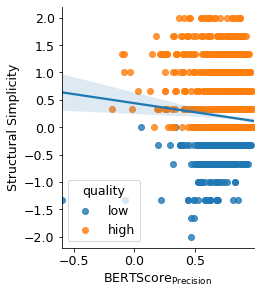

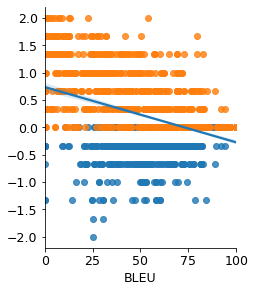

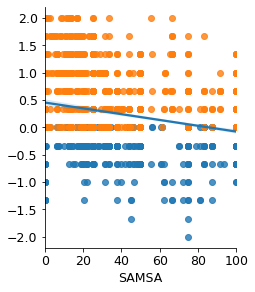

In [60]:
metric_name = {'bertscore_P': '$BERTScore_{Precision}$', 'bleu': 'BLEU', 'samsa': 'SAMSA'}
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 12.5})
for metric in ['bertscore_P', 'bleu', 'samsa']:
    auto_scores = df_metrics_struct_simplicity[df_metrics_struct_simplicity['test_set']=='hsplit'][['sent_id','sys_name', metric]]
    
    df_human_scores = df_benchmark_struct_simplicity[['sent_id','sys_name', 'structural_simplicity']]
    df_human_scores = df_human_scores.sort_values(by=['structural_simplicity'])
    df_human_scores['quality'] = 'low'
    df_human_scores['quality'].iloc[int(len(df_human_scores) / 2):] = 'high'

    df_aux = pd.merge(auto_scores, df_human_scores, on=['sent_id','sys_name'])

    corr, pvalue = pearsonr(df_aux[metric], df_aux['structural_simplicity'])
    
    graph = sns.lmplot(x=metric, y='structural_simplicity', hue='quality', data=df_aux, fit_reg=False, legend_out=False, height=4, aspect=0.9)
    reg_plot = sns.regplot(x=metric, y='structural_simplicity', data=df_aux, scatter=False, ax=graph.axes[0, 0])
    
    if metric == "bertscore_P":
        reg_plot.set(xlabel=metric_name[metric], ylabel='Structural Simplicity')
    else:
        reg_plot.set(xlabel=metric_name[metric], ylabel='')
        graph._legend.remove()
    
    # plt.title(f"r = {corr:.3f}")
    plt.savefig(f'{metric}_vs_structural_simplicity.pdf', dpi=300, bbox_inches='tight')

# Metrics across Types of Systems

In [79]:
def compute_correlations_per_approach(
    df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols
):
    results = {}
    for sys_type, df_scores_sys_type in df_benchmark.groupby(["sys_type"]):
        print(f"{sys_type}: {len(df_scores_sys_type)}")
        for aspect in aspects:
            for test_set in test_sets:
                df_metrics = df_segment_metrics[
                    (df_segment_metrics['test_set'] == test_set)
                    & (df_segment_metrics['sys_name'].isin(df_scores_sys_type["sys_name"]))
                ].drop(columns=["test_set"])
                results[
                    (sys_type, aspect, test_set)
                ] = compute_direct_assessment_correlations(
                    df_scores_sys_type,
                    df_metrics,
                    aspect,
                    segment_id_cols=segment_id_cols,
                )
    return results

In [80]:
def pprint_correlations_per_approach(results_correlations, aspects, test_sets, system_types):
    correlations = []
    for aspect in aspects:
        for sys_type in system_types:
            for test_set in test_sets:
                df_corr, _ = results_correlations[(sys_type, aspect, test_set)]
                df_corr = df_corr[['metric', 'corr']]
                df_corr.columns = ["metric", f"{aspect}_{test_set}_{sys_type}"]
                correlations.append(df_corr)

    df_corr_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=["metric"], how="outer"), correlations
    )
    
    return df_corr_metrics

## Simplicity-DA

In [ ]:
results_simplicity = compute_correlations_per_approach(df_benchmark_simplicity, df_metrics_simplicity, 
                                                       aspects=['simplicity'], test_sets=['asset'], segment_id_cols=['sent_id','sys_name'])

In [ ]:
results_simplicity[('NeuralSeq2Seq', 'simplicity', 'asset')][0]

In [ ]:
system_types = list(set(df_benchmark_simplicity['sys_type'].values))
df_corr_metrics_simplicity = pprint_correlations_per_approach(results_simplicity, aspects=['simplicity'], test_sets=['asset'], system_types=system_types)

In [ ]:
df_corr_metrics_simplicity

In [ ]:
print(df_corr_metrics_simplicity.to_latex(float_format="%.3f", index=False))

In [ ]:
aspect_to_plot = 'simplicity'
test_set_to_plot = 'asset'
sys_type_to_plot = ['PBMT', 'Semantics+PBMT']
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
i = 0
for (sys_type, aspect, test_set), (_, df_sig) in results_simplicity.items():
    if aspect == aspect_to_plot and test_set == test_set_to_plot and sys_type in sys_type_to_plot:
        ax = axes[i]
        sns.heatmap(df_sig, cmap="Greens", center=0.0, linewidth=0.05, cbar=False, robust=True, square=True, ax=ax)
        ax.set_title(sys_type)
        i+=1
plt.savefig('significance_systype_simplicity_complete_part2.pdf', dpi=300, bbox_inches='tight')

## Simplicity Gain

In [ ]:
results_simplicity_gain = compute_correlations_per_approach(df_benchmark_simplicity_gain, df_metrics_simplicity_gain, 
                                                            aspects=['simplicity_gain'], test_sets=EVAL_DATASETS, segment_id_cols=['sent_id','sys_name'])

In [ ]:
system_types = list(set(df_benchmark_simplicity_gain['sys_type'].values))
df_corr_metrics_simplicity_gain = pprint_correlations_per_approach(results_simplicity_gain, aspects=['simplicity_gain'], test_sets=['turk'], system_types=system_types)

In [ ]:
df_corr_metrics_simplicity_gain

## Structural Simplicity

In [81]:
results_struct_simplicity = compute_correlations_per_approach(df_benchmark_struct_simplicity, df_metrics_struct_simplicity, 
                                                              aspects=['structural_simplicity'], test_sets=EVAL_DATASETS, segment_id_cols=['sent_id','sys_name'])

NeuralSeq2Seq: 280
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
PBMT: 70
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
SBMT: 70
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Semantics: 140
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in

In [82]:
system_types = list(set(df_benchmark_struct_simplicity['sys_type'].values))
df_corr_metrics_struct_simplicity = pprint_correlations_per_approach(results_struct_simplicity, aspects=['structural_simplicity'], test_sets=['hsplit'], 
                                                                     system_types=system_types)

In [83]:
df_corr_metrics_struct_simplicity.columns

Index(['metric', 'structural_simplicity_hsplit_PBMT',
       'structural_simplicity_hsplit_Semantics+NeuralSeq2Seq',
       'structural_simplicity_hsplit_SBMT',
       'structural_simplicity_hsplit_Semantics',
       'structural_simplicity_hsplit_Semantics+PBMT',
       'structural_simplicity_hsplit_NeuralSeq2Seq'],
      dtype='object')

In [84]:
df_aux = df_corr_metrics_struct_simplicity[['metric', 
                                            'structural_simplicity_hsplit_PBMT', 'structural_simplicity_hsplit_SBMT', 'structural_simplicity_hsplit_NeuralSeq2Seq',
                                           'structural_simplicity_hsplit_Semantics', 'structural_simplicity_hsplit_Semantics+PBMT', 'structural_simplicity_hsplit_Semantics+NeuralSeq2Seq']]
print(df_aux.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrrrrr}
\toprule
                metric &  structural\_simplicity\_hsplit\_PBMT &  structural\_simplicity\_hsplit\_SBMT &  structural\_simplicity\_hsplit\_NeuralSeq2Seq &  structural\_simplicity\_hsplit\_Semantics &  structural\_simplicity\_hsplit\_Semantics+PBMT &  structural\_simplicity\_hsplit\_Semantics+NeuralSeq2Seq \\
\midrule
           bertscore\_P &                              0.501 &                              0.571 &                                       0.292 &                                   0.330 &                                        0.096 &                                              0.111 \\
          bertscore\_F1 &                              0.405 &                              0.497 &                                       0.553 &                                   0.180 &                                        0.049 &                                              0.362 \\
           bertscore\_R &                              0.339 &        

In [85]:
results_struct_simplicity[('Semantics+PBMT', 'structural_simplicity', 'hsplit')][0]

,metric,corr,p_value,is_winner
0,gmean_bleu_sari,0.184678,0.000003,False
1,amean_bleu_sari,0.174812,0.000010,False
2,sari,0.166370,0.000027,False
3,fkgl,0.154854,0.000095,False
4,bleu,0.147007,0.000213,False
5,ibleu,0.144544,0.000273,False
6,bertscore_R,0.134204,0.000733,False
7,fkbleu,0.119115,0.002749,False
8,amean_bleu_sari_samsa,0.111225,0.005192,False
9,bertscore_P,0.096045,0.015887,False


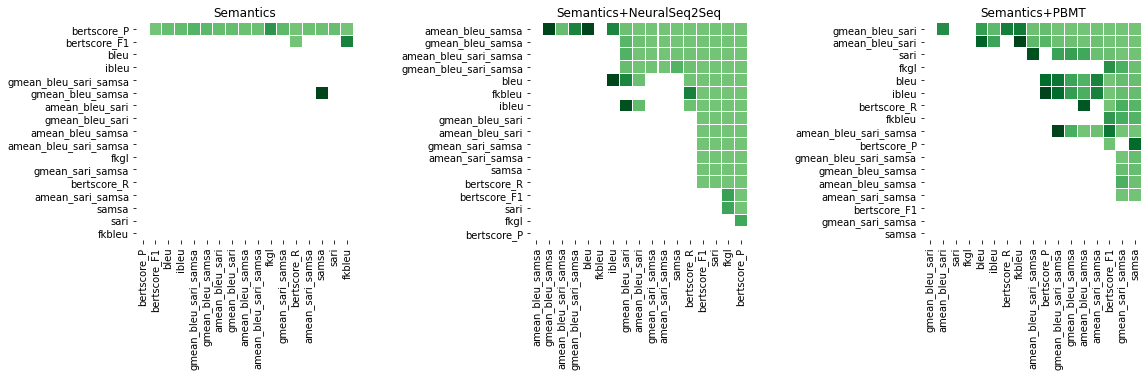

In [86]:
aspect_to_plot = 'structural_simplicity'
test_set_to_plot = 'hsplit'
sys_type_to_plot = ['Semantics', 'Semantics+PBMT', 'Semantics+NeuralSeq2Seq']
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
i = 0
for (sys_type, aspect, test_set), (_, df_sig) in results_struct_simplicity.items():
    if aspect == aspect_to_plot and test_set == test_set_to_plot and sys_type in sys_type_to_plot:
        ax = axes[i]
        sns.heatmap(df_sig, cmap="Greens", center=0.0, linewidth=0.05, cbar=False, robust=True, square=True, ax=ax)
        ax.set_title(sys_type)
        i+=1
plt.savefig('significance_systype_structural_simplicity_complete_part2.pdf', dpi=300, bbox_inches='tight')

In [120]:
from tseval.feature_extraction import count_sentence_splits

In [121]:
df_benchmark_struct_simplicity['with splitting'] = df_benchmark_struct_simplicity.apply(lambda row: count_sentence_splits(row['orig_sent'], row['simp_sent']) > 1, axis=1)

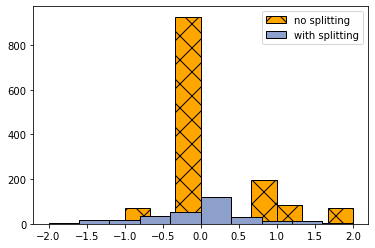

In [123]:
plt.hist(df_benchmark_struct_simplicity[(df_benchmark_struct_simplicity['with splitting'] == False)]['structural_simplicity'], 
    edgecolor='black', color=['orange'], label = 'no splitting', hatch="X")
plt.hist(df_benchmark_struct_simplicity[(df_benchmark_struct_simplicity['with splitting'] == True)]['structural_simplicity'], 
        edgecolor='black', color=['#8da0cb'], label = 'with splitting')
plt.legend(loc='upper right')
plt.savefig('scores_distribution_structural_simplicity_withsplit_vs_nosplit.pdf', dpi=300, bbox_inches='tight')

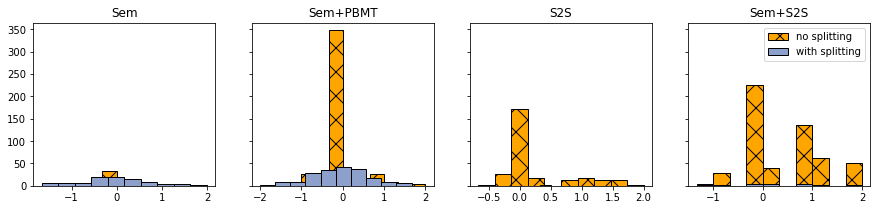

In [124]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 3), sharey=True)
for ax, (sys_type, sys_type_name) in zip(axes, [('Semantics', 'Sem'), ('Semantics+PBMT', 'Sem+PBMT'), ('NeuralSeq2Seq', 'S2S'), ('Semantics+NeuralSeq2Seq', 'Sem+S2S')]):
    ax.hist(df_benchmark_struct_simplicity[(df_benchmark_struct_simplicity['sys_type'] == sys_type) 
                                       & (df_benchmark_struct_simplicity['with splitting'] == False)]['structural_simplicity'], 
        edgecolor='black', color=['orange'], label = 'no splitting', hatch='x')
    ax.hist(df_benchmark_struct_simplicity[(df_benchmark_struct_simplicity['sys_type'] == sys_type) 
                                           & (df_benchmark_struct_simplicity['with splitting'] == True)]['structural_simplicity'], 
            edgecolor='black', color=['#8da0cb'], label = 'with splitting')
    ax.set_title(sys_type_name)
plt.legend(loc='upper right')
plt.savefig('scores_distribution_structural_simplicity_approaches_withsplit_vs_nosplit.pdf', dpi=300, bbox_inches='tight')

# Effect of References

In [1]:
def compute_correlations(df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols):
    results = {}
    for aspect in aspects: 
        for test_set in test_sets:
            df_metrics = df_segment_metrics[df_segment_metrics.test_set==test_set].drop(columns=['test_set'])
            results[(aspect, test_set)] = compute_direct_assessment_correlations(df_benchmark, 
                                                                                 df_metrics, 
                                                                                 aspect, 
                                                                                 segment_id_cols=segment_id_cols)
    return results

In [19]:
def pprint_correlations(results_correlations, aspects, test_sets):
    correlations = []
    for aspect in aspects:
        for test_set in test_sets:
            df_corr, _ = results_correlations[(aspect, test_set)]
            df_corr = df_corr[['metric', 'corr']]
            df_corr.columns = ["metric", f"{aspect}_{test_set}"]
            correlations.append(df_corr)

    df_corr_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=["metric"], how="outer"), correlations
    )
    
    return df_corr_metrics

In [9]:
df_metrics_simplicity = pd.read_csv("data/metrics_segment_benchmark_simplicity_with_all.csv")

In [10]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'samsa', 'fkgl', 'fkbleu', 'ibleu', 
                      'amean_bleu_sari', 'amean_sari_samsa', 
                      'gmean_bleu_sari', 'gmean_sari_samsa',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

In [11]:
df_metrics_simplicity = df_metrics_simplicity[['sent_id', 'sys_name', 'test_set'] + METRICS_TO_ANALYSE]

In [14]:
results_simplicity = compute_correlations(df_benchmark_simplicity, df_metrics_simplicity, 
                                          aspects=['simplicity'], test_sets=EVAL_DATASETS + ['all'], segment_id_cols=['sent_id','sys_name'])

Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...


In [28]:
results_simplicity[('simplicity', 'hsplit')][0]

,metric,corr,p_value,is_winner
0,bertscore_P,0.593975,1.728493e-58,True
1,bertscore_F1,0.497769,6.954998e-39,False
2,bertscore_R,0.382100,2.709435e-22,False
3,gmean_bleu_sari,0.285119,1.097735e-12,False
4,bleu,0.284966,1.129938e-12,False
5,ibleu,0.284349,1.269478e-12,False
6,amean_bleu_sari,0.275022,7.120458e-12,False
7,sari,0.192199,2.112533e-06,False
8,amean_sari_samsa,0.143658,4.157672e-04,False
9,gmean_sari_samsa,0.119361,3.410329e-03,False


In [20]:
df_corr_metrics_simplicity = pprint_correlations(results_simplicity, aspects=['simplicity'], test_sets=EVAL_DATASETS + ['all'])

In [24]:
df_corr_metrics_simplicity.sort_values(by=['simplicity_all'], ascending=False)

,metric,simplicity_asset,simplicity_turk,simplicity_hsplit,simplicity_all
0,bertscore_P,0.617463,0.612741,0.593975,0.629430
1,bertscore_F1,0.572982,0.537376,0.497769,0.575879
2,ibleu,0.503749,0.417733,0.284349,0.537022
5,bleu,0.496336,0.411836,0.284966,0.526417
3,amean_bleu_sari,0.502735,0.418024,0.275022,0.519141
4,bertscore_R,0.499577,0.440770,0.382100,0.505658
6,gmean_bleu_sari,0.475908,0.409892,0.285119,0.489579
7,sari,0.358708,0.340571,0.192199,0.352978
8,amean_sari_samsa,0.165872,0.166622,0.143658,0.155622
9,gmean_sari_samsa,0.155818,0.163818,0.119361,0.151746


In [25]:
print(df_corr_metrics_simplicity.sort_values(by=['simplicity_all'], ascending=False).to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrrr}
\toprule
           metric &  simplicity\_asset &  simplicity\_turk &  simplicity\_hsplit &  simplicity\_all \\
\midrule
      bertscore\_P &             0.617 &            0.613 &              0.594 &           0.629 \\
     bertscore\_F1 &             0.573 &            0.537 &              0.498 &           0.576 \\
            ibleu &             0.504 &            0.418 &              0.284 &           0.537 \\
             bleu &             0.496 &            0.412 &              0.285 &           0.526 \\
  amean\_bleu\_sari &             0.503 &            0.418 &              0.275 &           0.519 \\
      bertscore\_R &             0.500 &            0.441 &              0.382 &           0.506 \\
  gmean\_bleu\_sari &             0.476 &            0.410 &              0.285 &           0.490 \\
             sari &             0.359 &            0.341 &              0.192 &           0.353 \\
 amean\_sari\_samsa &             0.166 &            0.16

## All References vs Operation-Specific per Sentence

In [23]:
asset_orig, asset_refs = read_test_set("asset_test", as_lists=True)
turk_orig, turk_refs = read_test_set("turkcorpus_test", as_lists=True)
hsplit_orig, hsplit_refs = read_test_set("hsplit_test", as_lists=True)

# We create a dataset composed of all references together
all_orig = asset_orig
all_refs = asset_refs + turk_refs + hsplit_refs

asset_turk_orig = asset_orig
asset_turk_refs = asset_refs + turk_refs

EVAL_DATASETS = {
    "asset": (asset_orig, asset_refs, 10),
    "turk": (turk_orig, turk_refs, 8),
    "hsplit": (hsplit_orig, hsplit_refs, 4),
    "all": (all_orig, all_refs, 22),
    "asset+turk": (asset_turk_orig, asset_turk_refs, 18)
}

In [24]:
lowercase = False  # case-insensitive
tokenizer = "moses"

In [4]:
sents_to_eval = [
    read_sentences_to_evaluate(f"../human_ratings/benchmark_simplert/batch_{i}.csv")
    for i in range(1, 5)
]
df_sents_to_eval = pd.concat(sents_to_eval, ignore_index=True)

30it [00:00, 2813.14it/s]
30it [00:00, 3431.58it/s]
30it [00:00, 3312.34it/s]
30it [00:00, 3303.21it/s]


In [5]:
df_sents_to_eval

,sent_id,sys_name,orig_sent,simp_sent
0,268,ACCESS,Prunk is a member of Institute of European His...,Prunk is a member of Institute of European His...
1,67,SBMT-SARI,"In return, Rollo swore fealty to Charles, conv...","In return, Rollo swore fealty to Charles, conv..."
2,341,SBMT-SARI,From 1900 to 1920 many new facilities were con...,From 1900 to 1920 many new plants were built o...
3,278,PBMT-R,Mercury is similar in appearance to the Moon: ...,Mercury is similar in appearance to the Moon: ...
4,107,Hybrid,"He settled in London, devoting himself chiefly...","He settled in London, devoting himself."
...,...,...,...,...
595,210,Hybrid,Orchestration Stravinsky first conceived of wr...,Orchestration Stravinsky conceived of writing ...
596,202,Dress-Ls,"The album, however, was banned from many recor...",The album was banned from many record stores n...
597,194,PBMT-R,ISBN 1-876429-14-3 is an historic township loc...,Gunnedah is a historic town near Cowra in the ...
598,148,Dress-Ls,"Later, Esperanto speakers began to see the lan...",Esperanto speakers began to see the language a...


In [6]:
df_sents_to_eval = easse_labelling_with_simalign(df_sents_to_eval)

2020-09-10 17:39:45,900 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


Starting server with command: java -Xmx5G -cp /experiments/falva/easse/easse/resources/tools/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 40 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d6c16498b4ff473e.props -preload tokenize,ssplit,pos,lemma,ner,depparse


In [18]:
bertscore_rescale = BERTScorer(lang="en", rescale_with_baseline=True)

In [27]:
metrics = []
for _, row in tqdm(df_sents_to_eval.iterrows()):
    if row['splitting'] and not row['compression'] and not row['paraphrasing']: 
        test_set = 'hsplit'
    elif (row['compression'] or row['paraphrasing']) and not row['splitting']:
        test_set = 'asset+turk'
    else:
        test_set = 'asset'
        
    test_set_orig, test_set_refs, num_refs = EVAL_DATASETS[test_set]
    orig_sents, ref_sents = collect_references(
            [row["sent_id"]], test_set_orig, test_set_refs, num_refs
        )
    # BLEU
    bleu_sys_refs = corpus_bleu(
        [row["simp_sent"]],
        ref_sents,
        smooth_method="floor",
        tokenizer=tokenizer,
        lowercase=lowercase,
        use_effective_order=True,
    )

    # SARI
    sari_score, add_score, keep_score, del_score = corpus_sari(
        orig_sents,
        [row["simp_sent"]],
        ref_sents,
        tokenizer=tokenizer,
        lowercase=lowercase,
        use_f1_for_deletion=False,
        return_operation_scores=True
    )

    # iBLEU (alpha = 0.9)
    bleu_sys_orig = corpus_bleu(
        [row["simp_sent"]],
        [orig_sents],
        force=True,
        tokenizer=tokenizer,
        lowercase=lowercase,
    )
    ibleu_score = 0.9 * bleu_sys_refs - (1 - 0.9) * bleu_sys_orig

    # Avg. of BLEU and SARI
    amean_bleu_sari = np.mean([bleu_sys_refs, sari_score])
    gmean_bleu_sari = scipy.stats.gmean([bleu_sys_refs, sari_score])

    # Flesch
    fkgl_sys = corpus_fkgl([row["simp_sent"]], tokenizer=tokenizer)

    # FKBLEU
    fkgl_orig = corpus_fkgl(orig_sents, tokenizer=tokenizer)
    fk_diff = sigmoid(fkgl_sys - fkgl_orig)
    fkbleu_score = ibleu_score * fk_diff

    # BERTScore
    ref_sents = [ref for [ref] in ref_sents]
    bertscore_rescale_scores = bertscore_rescale.score([row["simp_sent"]], [ref_sents])

    metrics.append(
        {
            "sent_id": row["sent_id"],
            "sys_name": row["sys_name"],
            "test_set": test_set,
            "bleu": bleu_sys_refs,
            "sari": sari_score,
            "sari_add": add_score,
            "sari_keep": keep_score,
            "sari_del": del_score,
            "ibleu": ibleu_score,
            "amean_bleu_sari": amean_bleu_sari,
            "gmean_bleu_sari": gmean_bleu_sari,
            "fkgl": fkgl_sys,
            "fkbleu": fkbleu_score,
            "bertscore_P": bertscore_rescale_scores[0].cpu().item(),
            "bertscore_R": bertscore_rescale_scores[1].cpu().item(),
            "bertscore_F1": bertscore_rescale_scores[2].cpu().item(),
        }
    )

df_metrics_segment = pd.DataFrame(metrics)

20it [00:02, 10.19it/s]/home/falva/anaconda3/envs/mtl4ts/lib/python3.6/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
600it [00:53, 11.28it/s]


In [28]:
df_metrics_segment

,sent_id,sys_name,test_set,bleu,sari,sari_add,sari_keep,sari_del,ibleu,amean_bleu_sari,gmean_bleu_sari,fkgl,fkbleu,bertscore_P,bertscore_R,bertscore_F1
0,268,ACCESS,asset,82.802644,47.579917,12.077973,81.405824,49.255952,67.429755,65.191280,62.767371,7.633846,0.268007,0.904156,0.862443,0.883413
1,67,SBMT-SARI,asset+turk,67.801658,39.083659,3.304267,48.806719,65.139991,54.715578,53.442659,51.477538,11.056667,3.277390,0.921957,0.924982,0.920372
2,341,SBMT-SARI,asset+turk,61.436117,39.423251,5.158791,62.629901,50.481061,49.763566,50.429684,49.213935,17.142500,1.227814,0.767044,0.799759,0.773052
3,278,PBMT-R,asset+turk,86.506155,40.449427,2.322645,41.177313,77.848325,70.206586,63.477791,59.153397,11.547407,4.230873,0.780502,0.751494,0.756557
4,107,Hybrid,asset+turk,86.944174,40.612840,0.000000,49.755187,72.083333,72.976326,63.778507,59.422638,2.280000,0.793896,0.917693,0.747387,0.831554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,210,Hybrid,asset+turk,83.070185,46.106396,0.000000,75.356226,62.962963,67.246665,64.588290,61.887534,8.370000,39.625802,0.949457,0.930342,0.916086
596,202,Dress-Ls,asset+turk,100.000000,50.640409,2.846264,63.658297,85.416667,83.846009,75.320205,71.162075,7.190000,51.475261,1.000000,1.000000,1.000000
597,194,PBMT-R,asset+turk,47.947318,31.788174,8.007386,54.562060,32.795075,39.357168,39.867746,39.040462,10.310435,24.618682,0.209967,0.172067,0.192260
598,148,Dress-Ls,asset+turk,100.000000,31.153518,0.968625,53.843599,38.648330,85.726507,65.576759,55.815337,8.895238,0.003160,0.894883,0.555689,0.720652


In [29]:
df_metrics_segment.groupby('test_set').count()

,sent_id,sys_name,bleu,sari,sari_add,sari_keep,sari_del,ibleu,amean_bleu_sari,gmean_bleu_sari,fkgl,fkbleu,bertscore_P,bertscore_R,bertscore_F1
test_set,,,,,,,,,,,,,,,
asset,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
asset+turk,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542


In [52]:
def compute_correlations_per_quality(df_benchmark, df_segment_metrics, aspects, segment_id_cols):
    results = {}
    for aspect in aspects: 
        df_benchmark_sorted = df_benchmark.sort_values(by=[f'{aspect}_zscore'])
        df_scores_low = df_benchmark_sorted.head(int(len(df_benchmark_sorted) / 2))
        df_scores_high = df_benchmark_sorted.tail(int(len(df_benchmark_sorted) / 2))
        print(f"{aspect}: High ({len(df_scores_high)}) - Low ({len(df_scores_low)}) - All ({len(df_benchmark)})")
        for quality, df_scores in {'low': df_scores_low, 'high': df_scores_high, 'all': df_benchmark}.items():
            df_metrics = df_segment_metrics.drop(columns=['test_set'])
            results[(quality, aspect)] = compute_direct_assessment_correlations(df_scores, 
                                                                                df_metrics, 
                                                                                aspect, 
                                                                                segment_id_cols=segment_id_cols)
    return results

In [62]:
def pprint_correlations(results_correlations, aspects):
    correlations = []
    for aspect in aspects:
        for quality in ['low', 'high', 'all']:
            df_corr, _ = results_correlations[(quality, aspect)]
            df_corr = df_corr[['metric', 'corr']]
            df_corr.columns = ["metric", f"{aspect}_{quality}"]
            correlations.append(df_corr)

    df_corr_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=["metric"], how="outer"), correlations
    )
    
    return df_corr_metrics

In [43]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'fkgl', 'fkbleu', 'ibleu', 
                      'amean_bleu_sari', 'gmean_bleu_sari',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

In [44]:
df_metrics_segment = df_metrics_segment[['sent_id', 'sys_name', 'test_set'] + METRICS_TO_ANALYSE]

In [53]:
results_simplicity = compute_correlations_per_quality(df_benchmark_simplicity, df_metrics_segment, 
                                                      aspects=['simplicity'], segment_id_cols=['sent_id','sys_name'])

simplicity: High (300) - Low (300) - All (600)
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...
Computing correlations...
Determining if the difference in performance is significant...


In [68]:
results_simplicity[('high', 'simplicity')][0]

,metric,corr,p_value,is_winner
0,bertscore_P,0.276053,0.000001,False
1,ibleu,0.243521,0.000020,False
2,bleu,0.223346,0.000096,False
3,amean_bleu_sari,0.221199,0.000112,False
4,gmean_bleu_sari,0.205090,0.000350,False
5,bertscore_F1,0.201613,0.000442,False
6,bertscore_R,0.165235,0.004108,False
7,sari,0.115462,0.045695,False
8,fkgl,0.093468,0.106160,False
9,fkbleu,0.020202,0.727474,False


In [63]:
df_corr_metrics_simplicity = pprint_correlations(results_simplicity, aspects=['simplicity'])

In [64]:
df_corr_metrics_simplicity

,metric,simplicity_low,simplicity_high,simplicity_all
0,bertscore_P,0.543140,0.276053,0.634898
1,bertscore_F1,0.534331,0.201613,0.583902
2,bertscore_R,0.478600,0.165235,0.510859
3,amean_bleu_sari,0.418015,0.221199,0.522921
4,gmean_bleu_sari,0.409683,0.205090,0.495546
5,bleu,0.401937,0.223346,0.525337
6,ibleu,0.395613,0.243521,0.536045
7,sari,0.352113,0.115462,0.350300
8,fkgl,0.271669,0.093468,0.117057
9,fkbleu,0.126251,0.020202,0.098137


In [65]:
df_corr_metrics_simplicity.sort_values(by=['simplicity_all'], ascending=False)

,metric,simplicity_low,simplicity_high,simplicity_all
0,bertscore_P,0.543140,0.276053,0.634898
1,bertscore_F1,0.534331,0.201613,0.583902
6,ibleu,0.395613,0.243521,0.536045
5,bleu,0.401937,0.223346,0.525337
3,amean_bleu_sari,0.418015,0.221199,0.522921
2,bertscore_R,0.478600,0.165235,0.510859
4,gmean_bleu_sari,0.409683,0.205090,0.495546
7,sari,0.352113,0.115462,0.350300
8,fkgl,0.271669,0.093468,0.117057
9,fkbleu,0.126251,0.020202,0.098137


In [66]:
print(df_corr_metrics_simplicity.sort_values(by=['simplicity_all'], ascending=False).to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrr}
\toprule
          metric &  simplicity\_low &  simplicity\_high &  simplicity\_all \\
\midrule
     bertscore\_P &           0.543 &            0.276 &           0.635 \\
    bertscore\_F1 &           0.534 &            0.202 &           0.584 \\
           ibleu &           0.396 &            0.244 &           0.536 \\
            bleu &           0.402 &            0.223 &           0.525 \\
 amean\_bleu\_sari &           0.418 &            0.221 &           0.523 \\
     bertscore\_R &           0.479 &            0.165 &           0.511 \\
 gmean\_bleu\_sari &           0.410 &            0.205 &           0.496 \\
            sari &           0.352 &            0.115 &           0.350 \\
            fkgl &           0.272 &            0.093 &           0.117 \\
          fkbleu &           0.126 &            0.020 &           0.098 \\
\bottomrule
\end{tabular}

